https://www.ijert.org/research/an-immediate-formula-for-the-radius-of-curvature-of-a-bimetallic-strip-IJERTV2IS120106.pdf 
![Alt text](Timoshenko_bimetal_formula.png)

We make the substitution to directly replace (α₁ - α₂)(ΔT) with (ε₁ - ε₂) the differential strain

In [416]:
import numpy as np

def calculate_timoshenko_curvature(h1, h2, E1, E2, strain1, strain2, C):
    """
    Calculate the curvature of a bimorph actuator using the Timoshenko model.
    
    Parameters:
    -----------
    h1, h2 : float
        Thicknesses of layers 1 and 2 (meters)
    E1, E2 : float
        Young's moduli of layers 1 and 2 (Pa)
    strain1, strain2 : float
        Strain reduction of layers 1 and 2 (dimensionless)
        
    Returns:
    --------
    kappa : float
        Curvature (1/meter)
    radius : float
        Radius of curvature (meter)
    """
    # Calculate the differential strain
    delta_strain = strain1 - strain2
    
    # Calculate thickness ratio n
    n = h1 / h2
    
    # Calculate modulus-thickness ratio m
    m = (E1 * h1) / (E2 * h2)
    
    # Total thickness
    h = h1 + h2
    
    # Calculate curvature using the Timoshenko equation
    numerator = 6 * delta_strain * (1 + m)**2
    denominator = h * (3 * (1 + m)**2 + (1 + m*n) * (m**2 + 1/(m*n)))
    
    kappa = C * numerator / denominator
    radius = 1 / kappa if kappa != 0 else float('inf')
    
    return kappa, radius

In [417]:
import matplotlib.pyplot as plt
def piecewise_linear(x, x0, y0, slope):
    return np.piecewise(
        x, [x <= x0, x > x0], [lambda x: slope * (x - x0) + y0, lambda x: y0]
    )

def plot_piecewise_fit(x_data, params, y_data=None, title="Piecewise Linear Fit"):
    x0, y0, slope = params
    x_fit = np.linspace(min(x_data), max(x_data), 1000)
    y_fit = piecewise_linear(x_fit, x0, y0, slope)
    plt.figure(figsize=(10, 6))
    if y_data is not None:
        plt.scatter(x_data, y_data, color="b", label="Data")
    plt.plot(
        x_fit,
        y_fit,
        "r-",
        label=f"Fitted Function x0({x0:.4g}) y0 ({y0:.4g}) slope ({slope:.4g})",
    )
    plt.axvline(x=x0, color="g", linestyle="--", label=f"Breakpoint (x={x0:.2f})")
    plt.axhline(y=y0, color="k", linestyle=":", label=f"Steady value (y={y0:.2f})")
    plt.xlabel("Time (minutes)")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [418]:
TOTAL_TIME = 20 # minutes

#TODO: maybe taking dry Young's modulus will be necessary...
E_WT = 16.3e6  #converting MPa to Pa
E_BslA = 6.2e6
h_WT = 1.1e-3 # converting mm to m
# h_WT = 10.0e-3 # converting mm to m
h_BslA = 0.3e-3 
L_beam = 15e-3
C = 1.72 # this needs to be fit to the data

time_range = np.linspace(0, TOTAL_TIME, TOTAL_TIME * 2)
WT_strain = piecewise_linear(time_range, 14.38153001, -0.76155718, -0.05372784)
BslA_strain = piecewise_linear(time_range, 1.05555108, -0.12121155, -0.10489566)

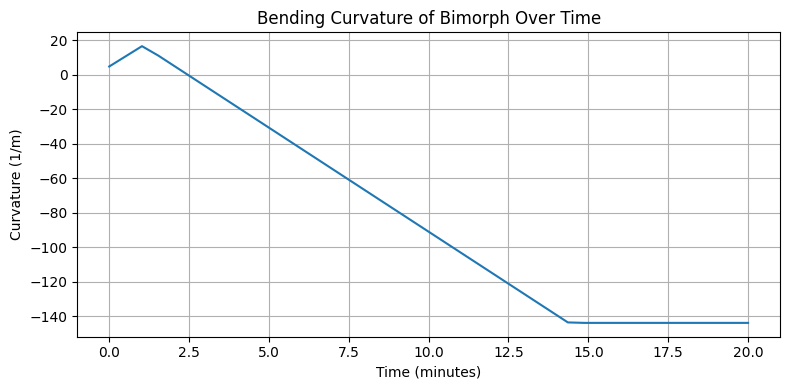

In [419]:
curvatures = []
radii = []

for s1, s2 in zip(WT_strain, BslA_strain):
    kappa, radius = calculate_timoshenko_curvature(h_WT, h_BslA, E_WT, E_BslA, s1, s2, C)
    curvatures.append(kappa)
    radii.append(radius)

curvatures = np.array(curvatures)
radii = np.array(radii)

# Step 7: Plot curvature over time
plt.figure(figsize=(8, 4))
plt.plot(time_range, curvatures)
plt.xlabel("Time (minutes)")
plt.ylabel("Curvature (1/m)")
plt.title("Bending Curvature of Bimorph Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

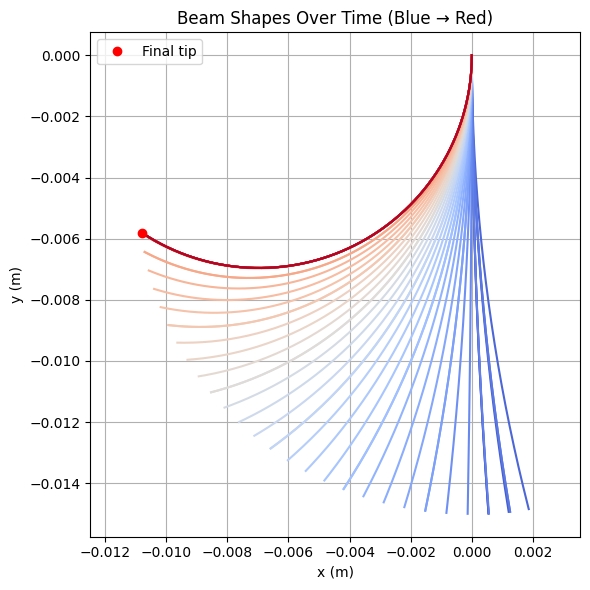

Final tip position: x = 0.00580 m, y = -0.01080 m


In [420]:
import matplotlib.pyplot as plt
import numpy as np

# Beam length
s_vals = np.linspace(0, L_beam, 200)  # arc-length along beam

# Select time points to visualize (early to late)
sample_indices = np.linspace(0, len(curvatures)-1, 50, dtype=int)
colors = plt.cm.coolwarm(np.linspace(0, 1, len(sample_indices)))

plt.figure(figsize=(6, 6))
for idx, color in zip(sample_indices, colors):
    kappa = curvatures[idx]

    if np.abs(kappa) < 1e-6:
        # Approximate straight beam
        x = s_vals
        y = np.zeros_like(s_vals)
    else:
        R = 1 / kappa
        theta = s_vals / R
        x = R * np.sin(theta)
        y = R * (1 - np.cos(theta))

    plt.plot(y, -x, color=color)

# Highlight the tip position of the final beam
final_kappa = curvatures[sample_indices[-1]]
if np.abs(final_kappa) > 1e-6:
    R_tip = 1 / final_kappa
    theta_tip = L_beam / R_tip
    x_tip = R_tip * np.sin(theta_tip)
    y_tip = R_tip * (1 - np.cos(theta_tip))
else:
    x_tip = L_beam
    y_tip = 0

plt.plot(y_tip, -x_tip, 'o', color='red', label='Final tip')

# Plot formatting
plt.axis('equal')
plt.title("Beam Shapes Over Time (Blue → Red)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Final tip position: x = {x_tip:.5f} m, y = {y_tip:.5f} m")


In [421]:
import os
import tempfile
import ffmpeg
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display


# Let's try running the video 2x faster than predicted
def process_bimorph_keyframes(
    video_path,
    curvatures,
    L_beam,
    x_offset,
    y_offset,
    beam_scale_factor=1,
    key_minutes=[1, 5, 10, 20],
    starting_time=0,
    time_difference=1,
):
    """Process key frames from the bimorph video and display overlays in the notebook"""
    # Define key minutes we want to capture

    # Convert minutes to seconds in the video (0.6 seconds per minute)
    key_timestamps = [
        (minute * 0.6 * time_difference) + (starting_time * 0.6) for minute in key_minutes
    ]

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video loaded: {fps} fps, {total_frames} total frames")

    # Calculate rows and columns for subplots
    n_rows = 5
    n_cols = int(np.ceil(len(key_minutes) / n_rows))

    # Create a figure with subplots in a grid layout
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

    # Flatten axes array for easier indexing if there are multiple subplots
    if len(key_minutes) > 1:
        axes_flat = axes.flatten()
    else:
        axes_flat = [axes]

    # Process each key frame
    freeze_frame = 0
    for i, (timestamp, minute) in enumerate(zip(key_timestamps, key_minutes)):
        if i < len(axes_flat):
            ax = axes_flat[i]
        else:
            print(
                f"Warning: More frames than subplot spaces. Skipping minute {minute}."
            )
            continue

        try:
            # Calculate frame number from timestamp
            frame_number = int(timestamp * fps)

            # Set video position to the frame
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

            # Read the frame
            ret, frame = cap.read()
            if not ret:
                cap.set(cv2.CAP_PROP_POS_FRAMES, freeze_frame)
                ret, frame = cap.read()
            else:
                freeze_frame = frame_number

            # Convert from BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Display the frame
            ax.imshow(frame_rgb)

            # Calculate the proportional position in the curvatures array
            time_fraction = minute / max(key_minutes)
            frame_idx = int(time_fraction * (len(curvatures) - 1))
            kappa = curvatures[frame_idx]

            # Calculate beam shape
            s_vals = np.linspace(0, L_beam, 200)

            if np.abs(kappa) < 1e-6:
                # Straight beam
                x = s_vals
                y = np.zeros_like(s_vals)
            else:
                R = 1 / kappa
                theta = s_vals / R
                x = R * np.sin(theta)
                y = R * (1 - np.cos(theta))

            # Scale and position to match the video frame
            # We'll fix the beam at the top center and let it hang down
            scale_factor = frame.shape[0] / (
                beam_scale_factor * L_beam
            )  # Adjust as needed
            # x_offset = frame.shape[1] // 2  # Center horizontally
            # y_offset = frame.shape[0] // 6  # Fixed at the top with some margin

            # Plot the beam - using y, -x to match your original orientation
            ax.plot(
                y * scale_factor + x_offset,
                x * scale_factor + y_offset,
                color="red",
                linewidth=3,
                alpha=0.7,
            )

            # Add tip point
            # if np.abs(kappa) > 1e-6:
            #     R_tip = 1 / kappa
            #     theta_tip = L_beam / R_tip
            #     x_tip = R_tip * np.sin(theta_tip)
            #     y_tip = R_tip * (1 - np.cos(theta_tip))
            # else:
            #     x_tip = L_beam
            #     y_tip = 0
            # print(
            #     "tip point ",
            #     y_tip * scale_factor + x_offset,
            #     x_tip * scale_factor + y_offset,
            # )
            # ax.plot(
            #     y_tip * scale_factor + x_offset,
            #     x_tip * scale_factor + y_offset,
            #     "o",
            #     color="blue",
            #     markersize=8,
            # )

            # Add timestamp and information
            # ax.text(
            #     10,
            #     30,
            #     f"Time: {minute} min",
            #     fontsize=12,
            #     color="white",
            #     bbox=dict(facecolor="black", alpha=0.7),
            # )
            # ax.text(
            #     10,
            #     frame.shape[0] - 20,
            #     f"κ = {kappa:.5f} (1/m)",
            #     fontsize=10,
            #     color="white",
            #     bbox=dict(facecolor="black", alpha=0.7),
            # )

            # Set title and remove axes
            ax.set_title(f"Minute {minute}")
            ax.axis("off")

        except Exception as e:
            print(f"Error processing frame at minute {minute}: {str(e)}")
            ax.text(
                0.5,
                0.5,
                f"Error: {str(e)}",
                horizontalalignment="center",
                verticalalignment="center",
            )
            ax.axis("off")

    # Release the video capture
    cap.release()

    plt.tight_layout()
    plt.show()

    # Also create a separate figure showing just the beam evolution for reference
    display_beam_evolution(curvatures, L_beam, key_minutes)

    return


def display_beam_evolution(curvatures, L_beam, key_minutes=None):
    print("in display_beam_evolution with key_minutes", key_minutes)
    """Display the evolution of beam shapes separately"""
    # Beam length
    s_vals = np.linspace(0, L_beam, 200)  # arc-length along beam

    # If key_minutes is provided, use those indices, otherwise sample evenly
    if key_minutes is not None:
        # Calculate indices based on minutes
        max_minute = max(key_minutes)
        sample_indices = [
            int((minute / max_minute) * (len(curvatures) - 1)) for minute in key_minutes
        ]
        colors = plt.cm.viridis(np.linspace(0, 1, len(sample_indices)))
    else:
        # Select time points to visualize (early to late)
        sample_indices = np.linspace(0, len(curvatures) - 1, 10, dtype=int)
        colors = plt.cm.viridis(np.linspace(0, 1, len(sample_indices)))

    plt.figure(figsize=(8, 8))
    for idx, color in zip(sample_indices, colors):
        kappa = curvatures[idx]

        if np.abs(kappa) < 1e-6:
            # Approximate straight beam
            x = s_vals
            y = np.zeros_like(s_vals)
        else:
            R = 1 / kappa
            theta = s_vals / R
            x = R * np.sin(theta)
            y = R * (1 - np.cos(theta))

        # minute = key_minutes[sample_indices.tolist().index(idx)] if key_minutes else idx
        plt.plot(y, -x, color=color)

    # Plot formatting
    plt.axis("equal")
    plt.title("Beam Shapes Over Time")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Video loaded: 30.0 fps, 690 total frames


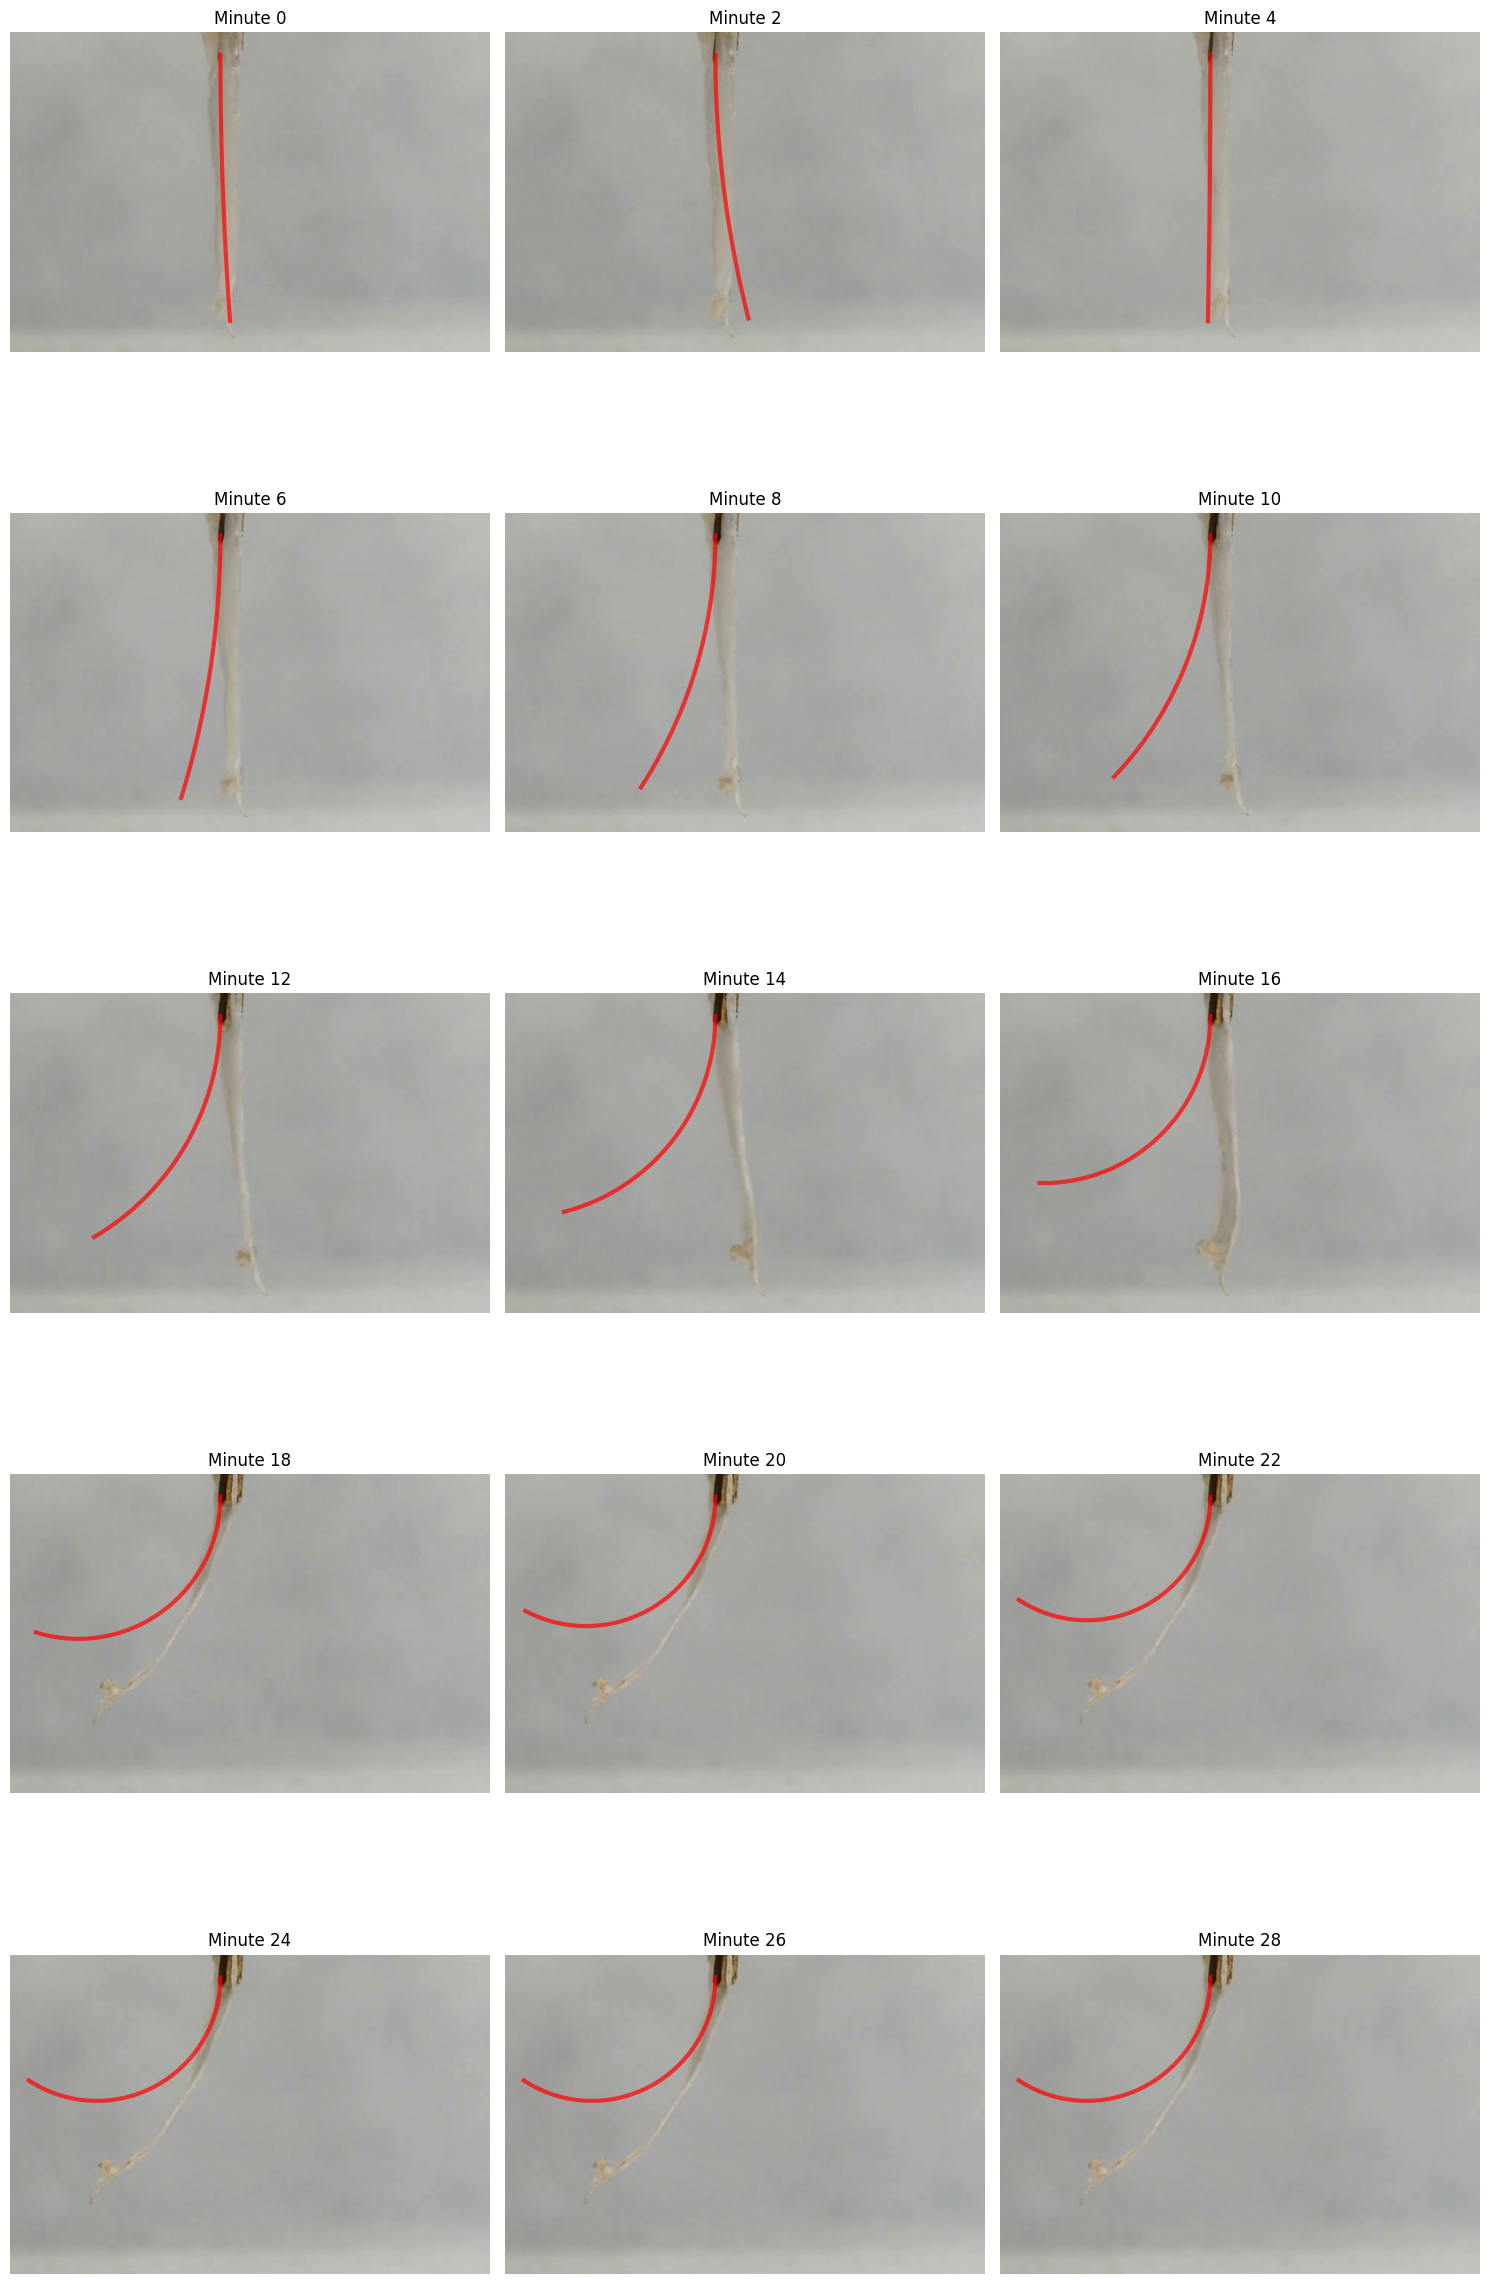

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


in display_beam_evolution with key_minutes range(0, 30, 2)


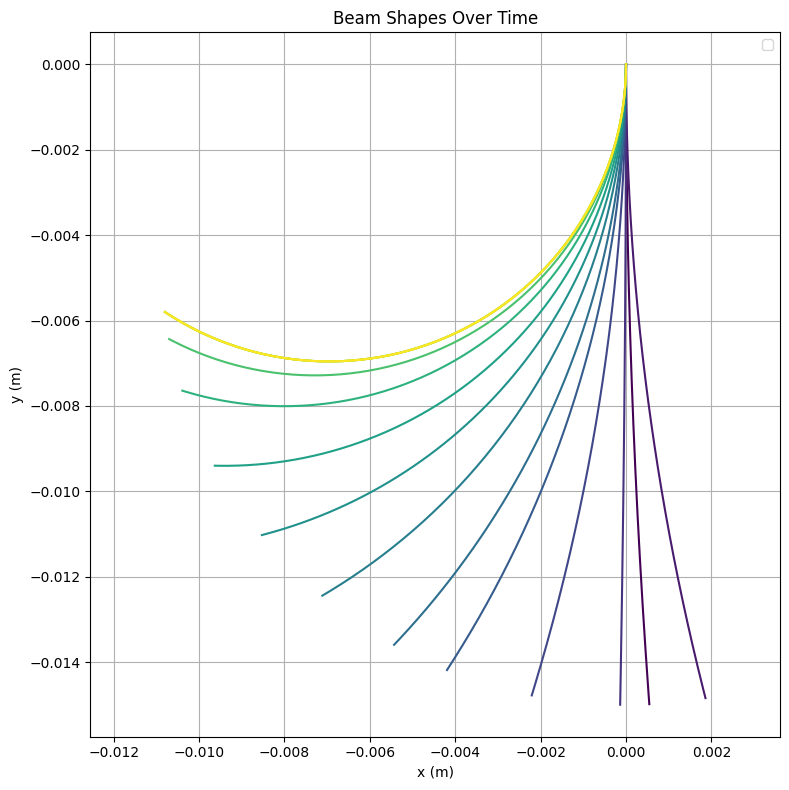

In [422]:
video_path = (
    "../bimorph_videos/bimorph_idx5_100x.mov"  # Update with your actual video path
)

process_bimorph_keyframes(
    video_path,
    curvatures,
    L_beam,
    x_offset=280,
    y_offset=30,
    time_difference=1.2,
    beam_scale_factor=1.2,
    starting_time=10,
    key_minutes=range(0, 30, 2),
)

In [ ]:
import cv2
import numpy as np
import json
import os
import base64
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import ffmpeg
import shutil
from io import BytesIO
from matplotlib.colors import LinearSegmentedColormap



def moving_average(positions, window):
    """Apply moving average smoothing to a list of positions"""
    # Convert list of (x,y) tuples or dicts to separate x and y arrays
    if isinstance(positions[0], dict):
        x_vals = [pos["x"] for pos in positions]
        y_vals = [pos["y"] for pos in positions]
    else:
        x_vals = [pos[0] for pos in positions]
        y_vals = [pos[1] for pos in positions]

    # Apply moving average to x and y separately
    x_smooth = []
    y_smooth = []

    for i in range(len(x_vals)):
        # Skip smoothing for first and last (window//2) points
        if i < window // 2 or i >= len(x_vals) - window // 2:
            x_smooth.append(x_vals[i])
            y_smooth.append(y_vals[i])
            continue

        # Calculate window boundaries for center points
        start = i - window // 2
        end = i + window // 2 + 1

        # Calculate averages
        x_avg = sum(x_vals[start:end]) / (end - start)
        y_avg = sum(y_vals[start:end]) / (end - start)

        x_smooth.append(int(x_avg))
        y_smooth.append(int(y_avg))

    # Return as list of tuples
    return list(zip(x_smooth, y_smooth))


def create_beam_tracking_composite(
    json_file_path,
    video_path,
    curvatures,
    L_beam,
    stalling_frames=0,
    starting_frame=0,
    output_folder="beam_composite_output",
    frames_folder="temp_beam_frames",
    time_points=[1, 5, 10, 20],  # in minutes
    beam_scale_factor=1,
    x_offset=None,
    y_offset=None,
    frame_interval=0.6,
    show_progress=True,
):
    # Create output folders
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(frames_folder, exist_ok=True)

    # Clean any existing files in the temp frames folder
    for filename in os.listdir(frames_folder):
        file_path = os.path.join(frames_folder, filename)
        if os.path.isdir(file_path):
            shutil.rmtree(file_path)
        else:
            os.remove(file_path)

    # Extract frames at the specified interval
    print("Extracting frames from video...")
    extract_frames(video_path, frames_folder, frame_interval)
    print("Frame extraction complete.")

    # Get video dimensions from a sample frame
    sample_frame_path = os.path.join(frames_folder, "frame_001.png")
    sample_frame = cv2.imread(sample_frame_path)
    if sample_frame is None:
        raise ValueError(f"Could not read sample frame at {sample_frame_path}")

    height, width = sample_frame.shape[:2]

    # Process each time point
    for time_point in time_points:
        print(f"Processing composite for time point: {time_point} minutes")
        with open(json_file_path, "r") as f:
            tracking_data = json.load(f)
        tracking_data["frames"] = tracking_data["frames"][
            starting_frame : starting_frame + time_point + 1
        ]
        composite = np.ones((height, width, 3), dtype=np.float32) * 255 # White background

        num_frames = len(tracking_data["frames"])
        min_alpha = 0.02
        max_alpha = 1.0

        for i, frame_data in enumerate(tracking_data["frames"]):
            composite_frame_index = frame_data["frame_index"]
            frame_path = os.path.join(
                frames_folder, f"frame_{composite_frame_index + 1:03d}.png"
            )

            if os.path.exists(frame_path):
                frame = cv2.imread(frame_path)
            else:
                print(f"Error: Frame file not found: {frame_path}")
                continue

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            mask_base64 = frame_data["mask"]
            mask_bytes = base64.b64decode(mask_base64)
            mask_array = np.frombuffer(mask_bytes, dtype=np.uint8)
            binary_mask = cv2.imdecode(mask_array, cv2.IMREAD_GRAYSCALE)
            masked_frame = cv2.bitwise_and(frame_rgb, frame_rgb, mask=binary_mask)

            # Normalize mask to use for alpha blending
            mask_3d = np.repeat((binary_mask > 0)[:, :, np.newaxis], 3, axis=2)

            # Compute alpha: fade from min_alpha to max_alpha linearly
            if i == len(tracking_data["frames"]) - 1:
                alpha = max_alpha
            else:
                progress = i / (num_frames - 1)
                alpha = min_alpha + (max_alpha/2 - min_alpha) * (progress ** 2)

            composite[mask_3d] = (
                composite[mask_3d] * (1 - alpha) + masked_frame[mask_3d] * alpha
            )

        # Convert composite back to uint8 for saving/display
        final_composite = np.clip(composite, 0, 255).astype(np.uint8)

        # plt.imshow(final_composite)

        """
            Back to the beam shape overlays!
        """
        original_time_point = time_point
        time_point = max(0, time_point - stalling_frames)

        # Calculate beam shapes for this time point
        # Determine how many beams to show based on the time point's position in time_points
        num_beams = time_points.index(time_point) + 1
        beam_times = time_points[:num_beams]

        # Calculate which curvature indices to use based on the time points
        max_time = max(time_points)
        curvature_indices = [
            int((t / max_time) * (len(curvatures) - 1)) for t in beam_times
        ]
        print("curvature_indices", curvature_indices)
        # cmap = cm.get_cmap("coolwarm")
        pink_red_cmap = LinearSegmentedColormap.from_list(
            "pink_to_red", ["#ffc0cb", "#ff0000"]  
        )

        colors = [
            pink_red_cmap(
                i / (len(curvature_indices) - 1) if len(curvature_indices) > 1 else 0.5
            )
            for i in range(len(curvature_indices))
        ]

        # Convert composite to RGB for matplotlib
        # This 
        # composite_rgb = final_composite#cv2.cvtColor(final_composite, cv2.COLOR_BGR2RGB)
        # This is a double conversion, but it makes the image kinda nice... :^P
        # composite_rgb = cv2.cvtColor(final_composite, cv2.COLOR_BGR2RGB)
        composite_rgb = final_composite # cv2.cvtColor(final_composite, cv2.COLOR_BGR2RGB)

        # Create a figure and axis for the composite with beams
        plt.figure(
            figsize=(width / 100, height / 100), dpi=100
        )  # Size to match video dimensions
        plt.imshow(composite_rgb)

        # Calculate and draw beam shapes
        s_vals = np.linspace(0, L_beam, 200)  # arc-length along beam
        scale_factor = height / (beam_scale_factor * L_beam)

        # Plot a straight beam for the first curvature
        x = s_vals
        y = np.zeros_like(s_vals)
        plt.plot(
            y * scale_factor + x_offset,
            x * scale_factor + y_offset,
            color=colors[0],
            linewidth=1,
            alpha=0.8,
        )
        for idx, color in zip(curvature_indices, colors):
            kappa = curvatures[idx]
            if curvature_indices == [0]:
                # Straight beam
                x = s_vals
                y = np.zeros_like(s_vals)
            else:
                R = 1 / kappa
                theta = s_vals / R
                x = R * np.sin(theta)
                y = R * (1 - np.cos(theta))

            plt.plot(
                y * scale_factor + x_offset,
                x * scale_factor + y_offset,
                color=color,
                linewidth=1,
                alpha=0.8,
            )

        plt.title(f"Time: {original_time_point} minutes")
        plt.axis("off")
        plt.tight_layout(pad=0)

        # Save the composite image
        output_path = os.path.join(output_folder, f"composite_{original_time_point}min.png")
        plt.savefig(output_path, bbox_inches="tight", pad_inches=0, dpi=300)

        if show_progress:
            plt.show()
        else:
            plt.close()

    # Clean up temporary frames
    if not show_progress:
        for filename in os.listdir(frames_folder):
            file_path = os.path.join(frames_folder, filename)
            if os.path.isdir(file_path):
                shutil.rmtree(file_path)
            else:
                os.remove(file_path)

    print(f"All composite images have been saved to {output_folder}")


def extract_frames(video_path, output_folder, interval):
    """Extract frames from video at specified interval in seconds"""
    os.makedirs(output_folder, exist_ok=True)
    ffmpeg.input(video_path, ss=0).output(
        f"{output_folder}/frame_%03d.png", vf=f"fps=1/{interval}"
    ).run(quiet=True)



Extracting frames from video...


python(62447) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Frame extraction complete.
Processing composite for time point: 0 minutes
curvature_indices [0]


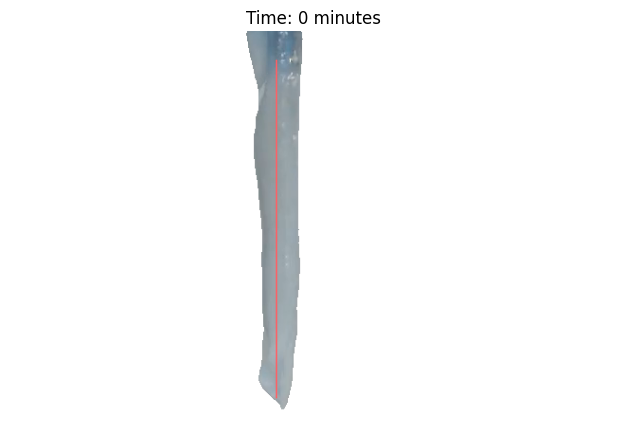

Processing composite for time point: 1 minutes
curvature_indices [0]


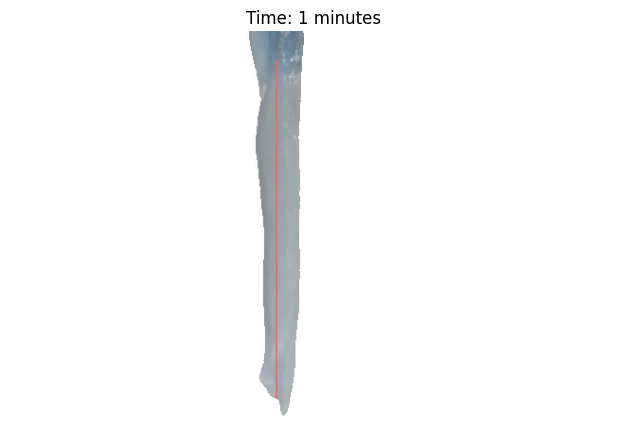

Processing composite for time point: 2 minutes
curvature_indices [0]


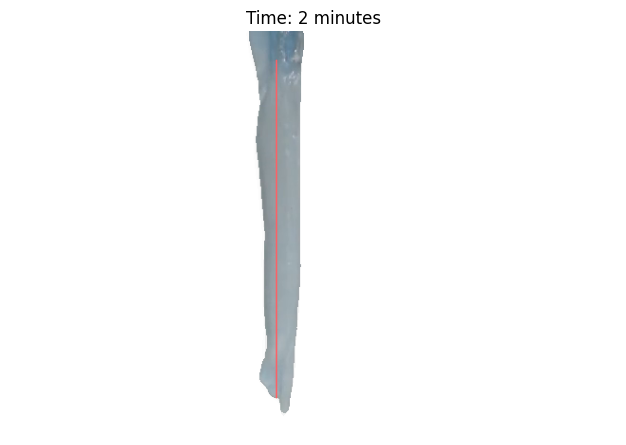

Processing composite for time point: 3 minutes
curvature_indices [0]


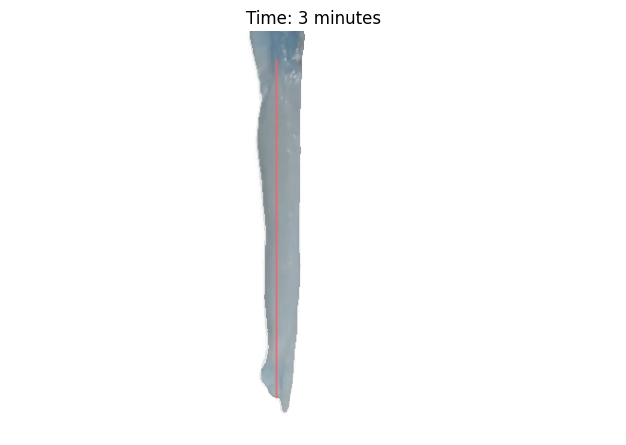

Processing composite for time point: 4 minutes
curvature_indices [0]


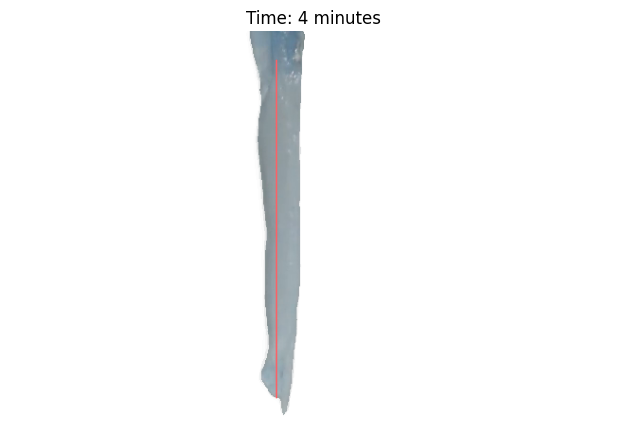

Processing composite for time point: 5 minutes
curvature_indices [0]


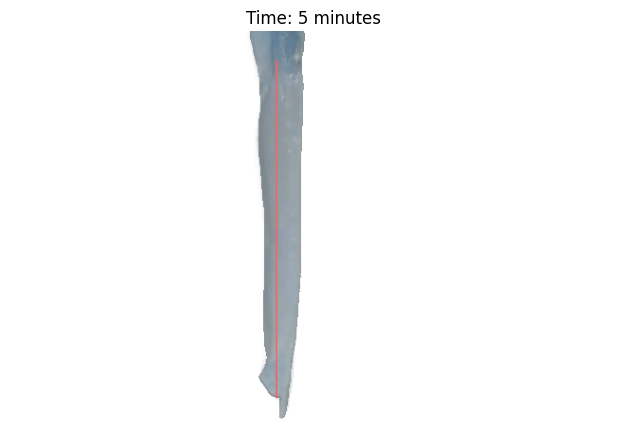

Processing composite for time point: 6 minutes
curvature_indices [0]


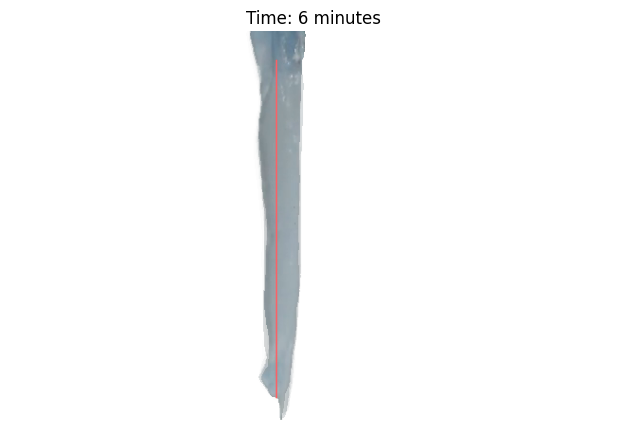

Processing composite for time point: 7 minutes
curvature_indices [0]


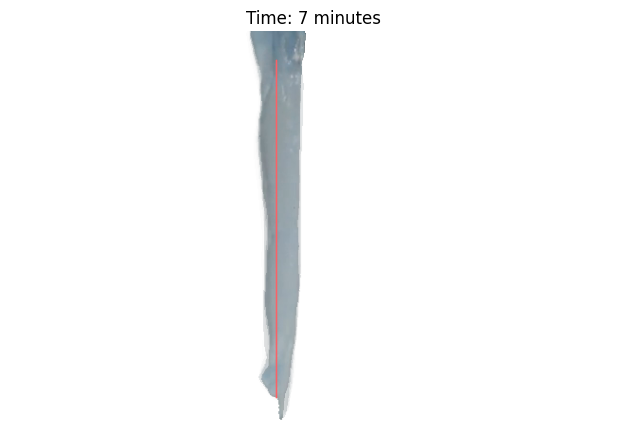

Processing composite for time point: 8 minutes
curvature_indices [0]


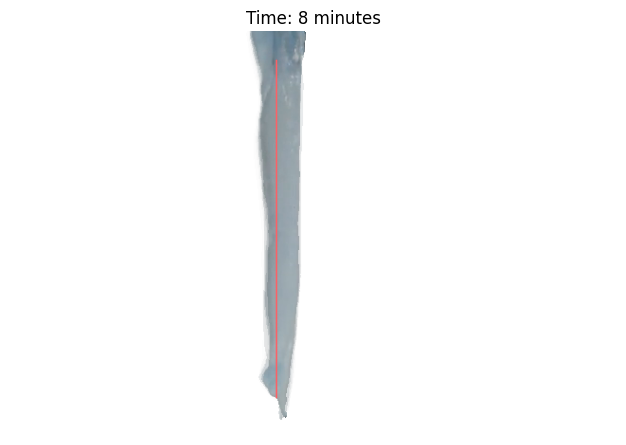

Processing composite for time point: 9 minutes
curvature_indices [0]


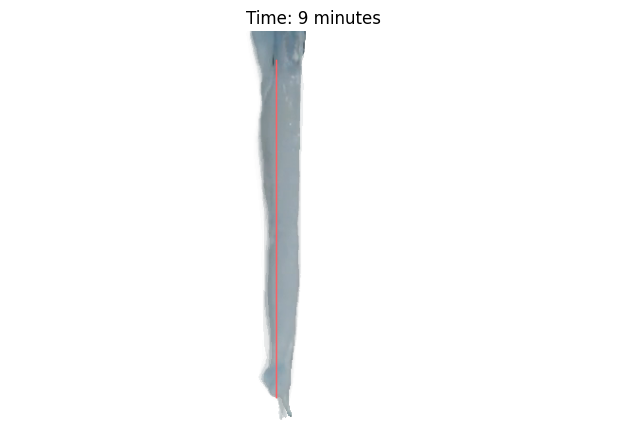

Processing composite for time point: 10 minutes
curvature_indices [0]


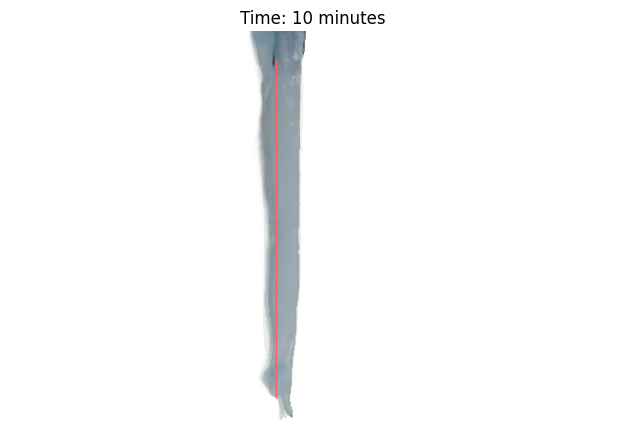

Processing composite for time point: 11 minutes
curvature_indices [0]


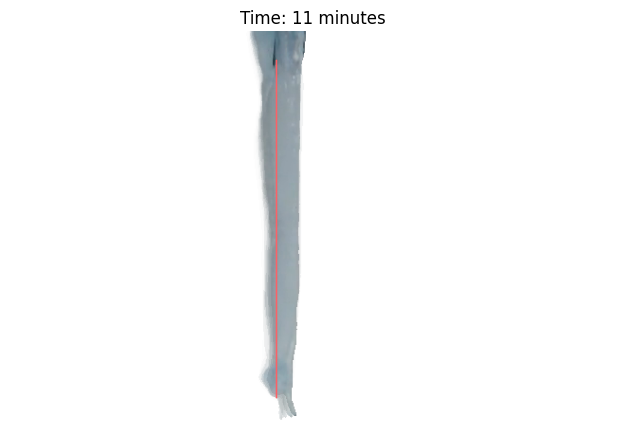

Processing composite for time point: 12 minutes
curvature_indices [0]


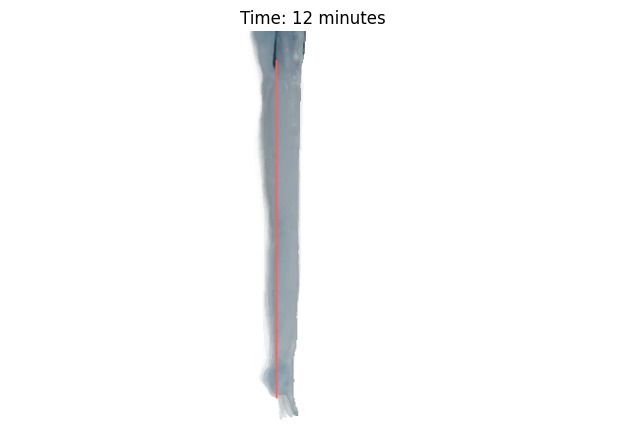

Processing composite for time point: 13 minutes
curvature_indices [0]


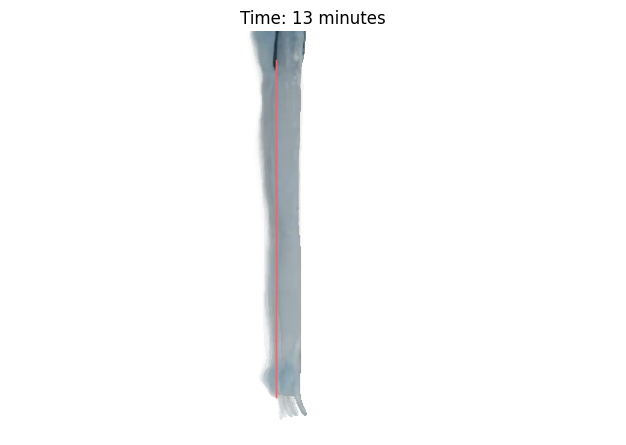

Processing composite for time point: 14 minutes
curvature_indices [0]


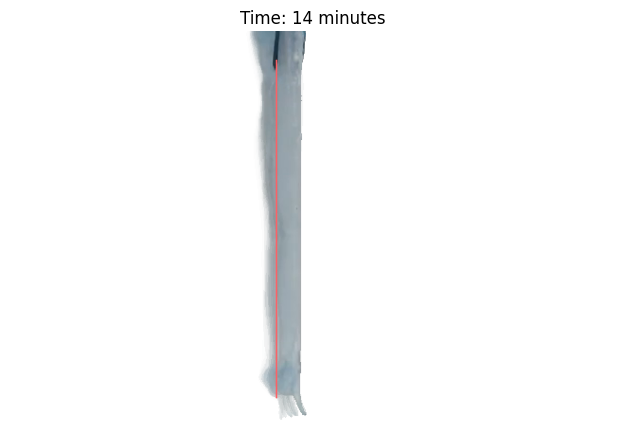

Processing composite for time point: 15 minutes
curvature_indices [0]


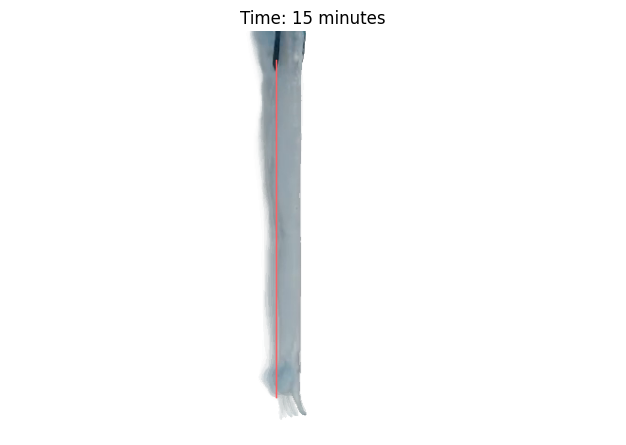

Processing composite for time point: 16 minutes
curvature_indices [0]


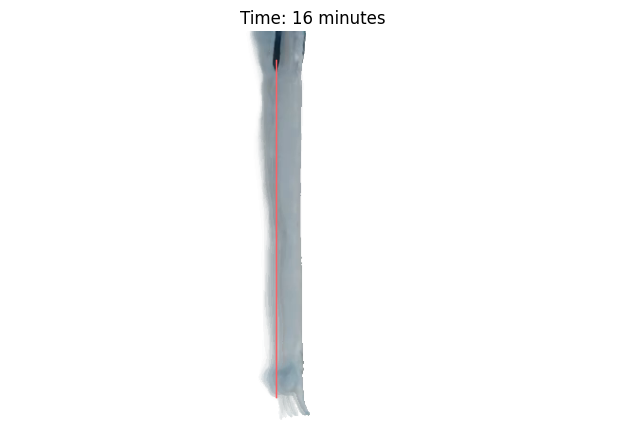

Processing composite for time point: 17 minutes
curvature_indices [0]


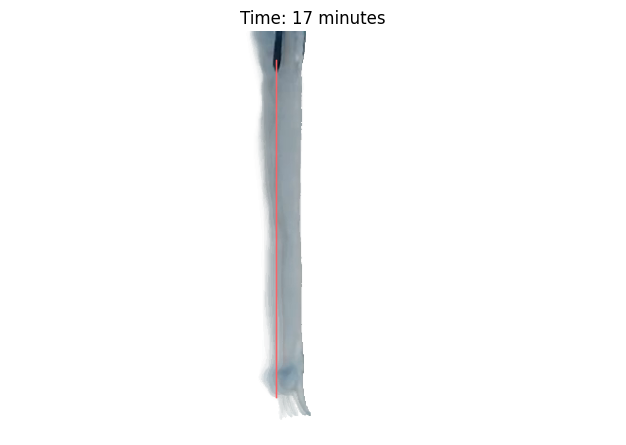

Processing composite for time point: 18 minutes
curvature_indices [0, 0]


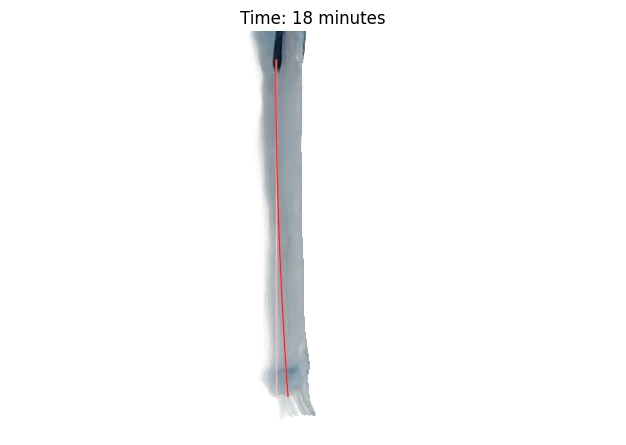

Processing composite for time point: 19 minutes
curvature_indices [0, 0, 1]


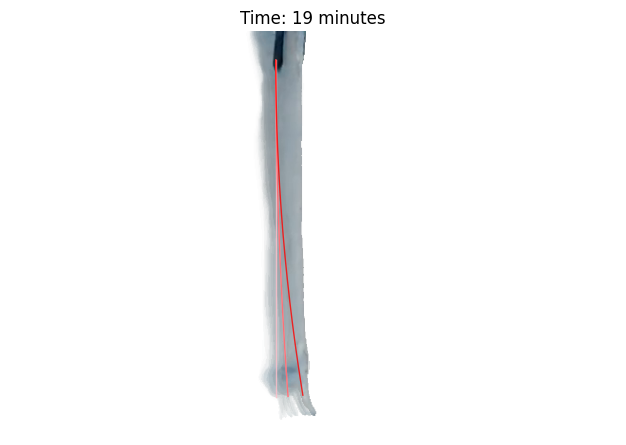

Processing composite for time point: 20 minutes
curvature_indices [0, 0, 1, 2]


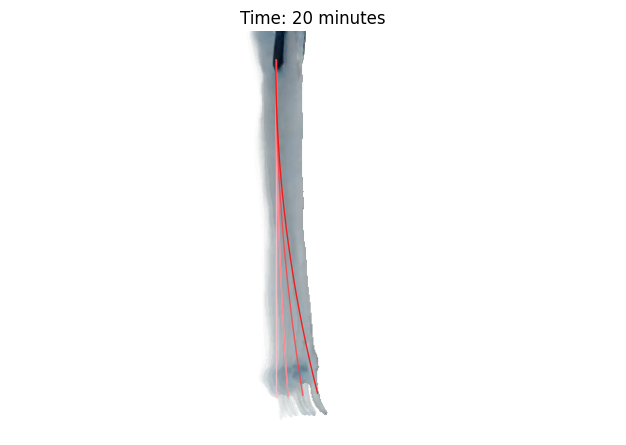

Processing composite for time point: 21 minutes
curvature_indices [0, 0, 1, 2, 3]


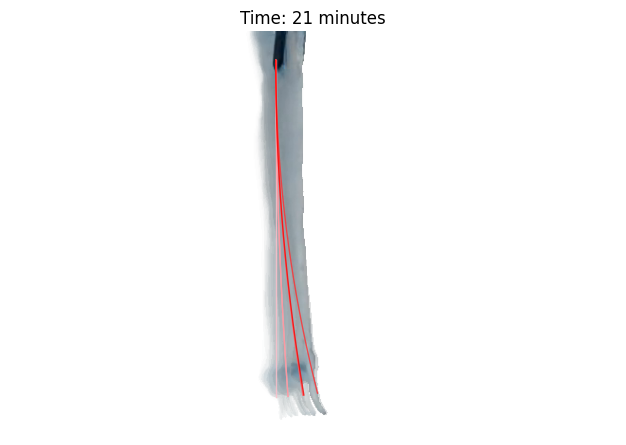

Processing composite for time point: 22 minutes
curvature_indices [0, 0, 1, 2, 3, 3]


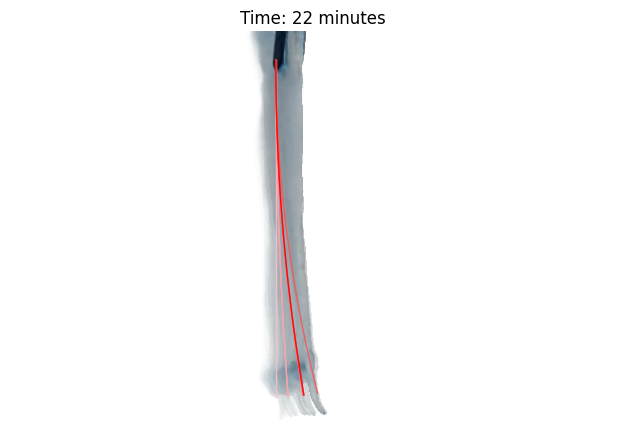

Processing composite for time point: 23 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4]


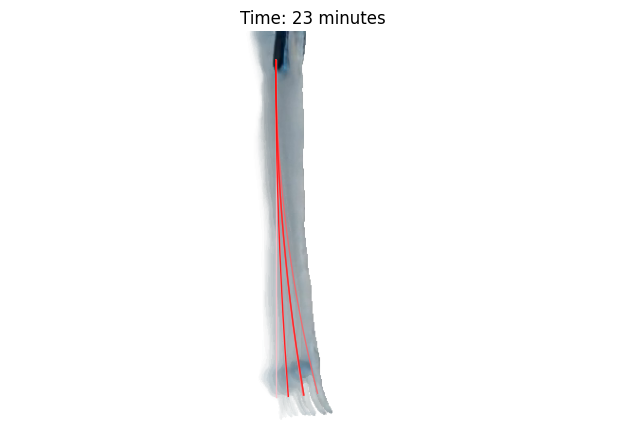

Processing composite for time point: 24 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5]


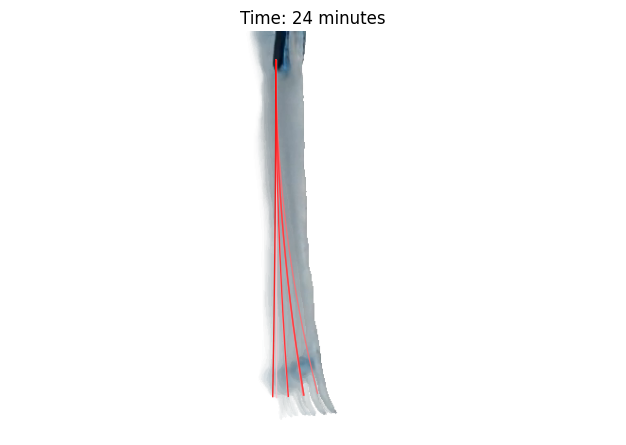

Processing composite for time point: 25 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6]


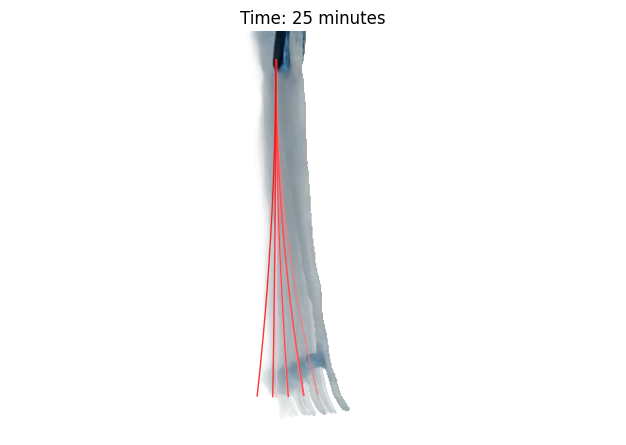

Processing composite for time point: 26 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7]


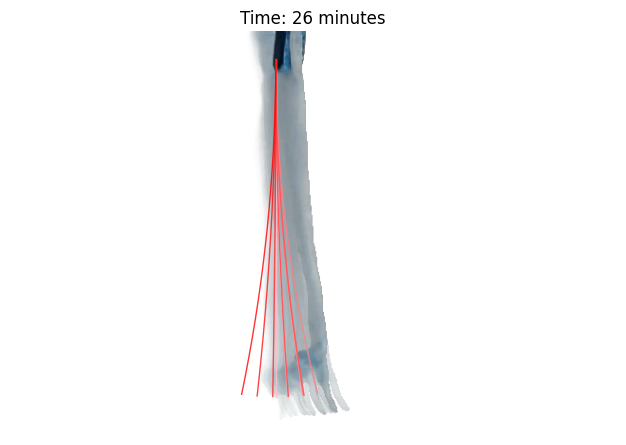

Processing composite for time point: 27 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7]


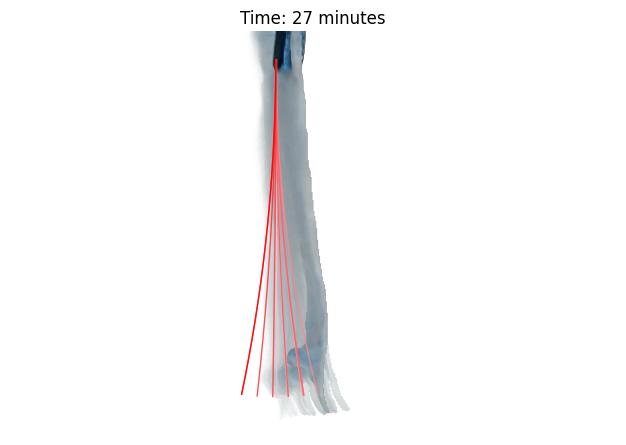

Processing composite for time point: 28 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8]


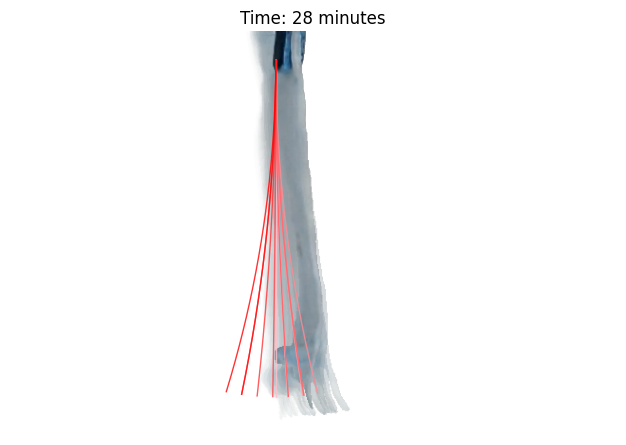

Processing composite for time point: 29 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9]


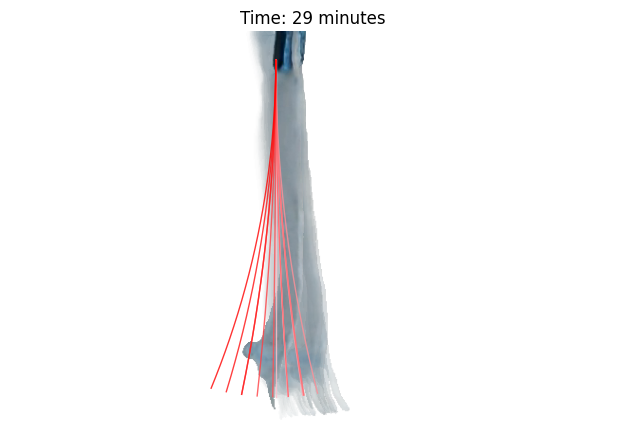

Processing composite for time point: 30 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10]


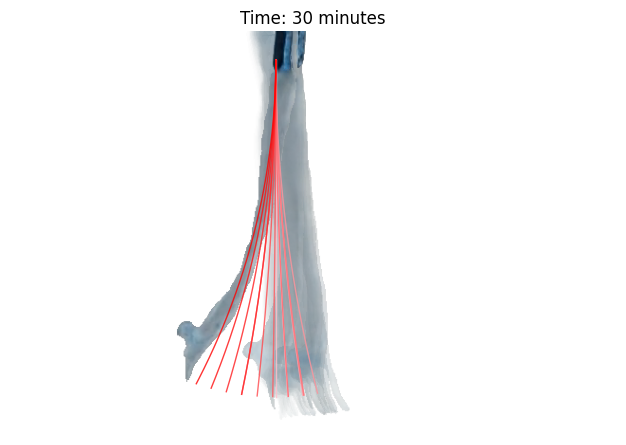

Processing composite for time point: 31 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10]


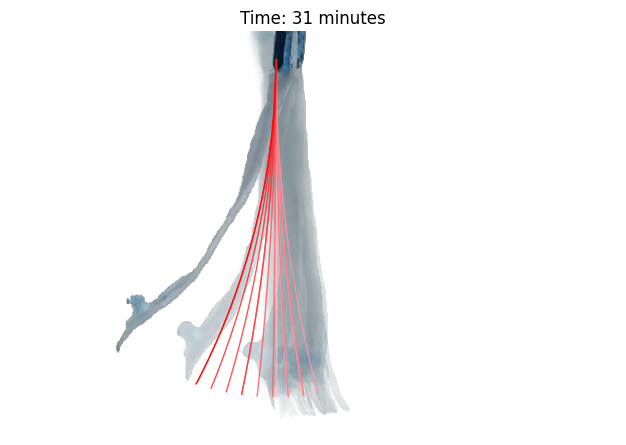

Processing composite for time point: 32 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11]


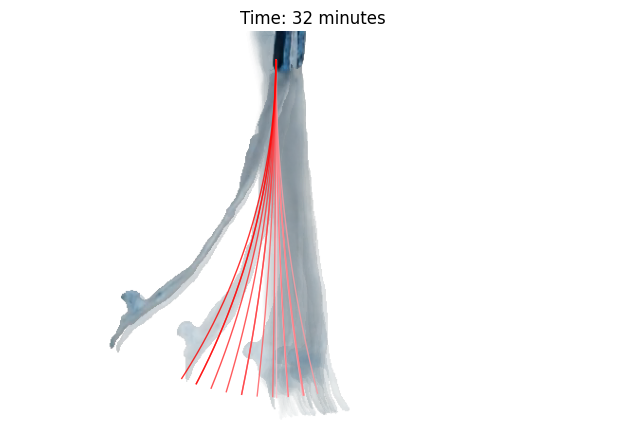

Processing composite for time point: 33 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12]


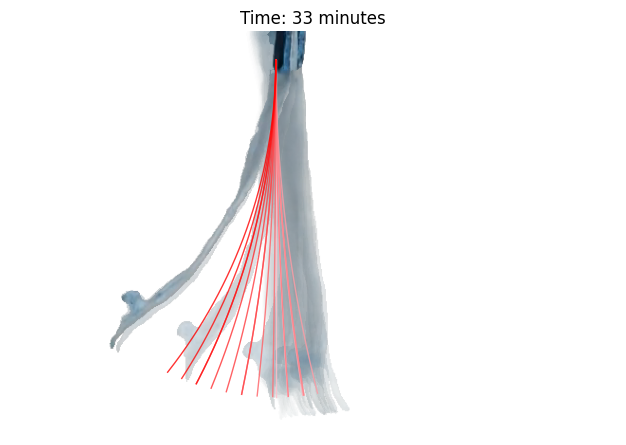

Processing composite for time point: 34 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13]


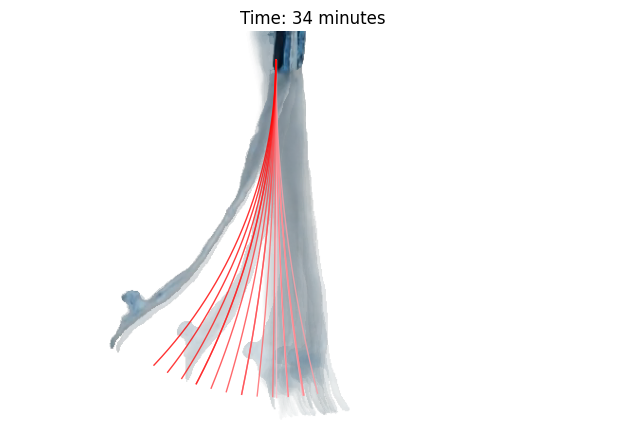

Processing composite for time point: 35 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14]


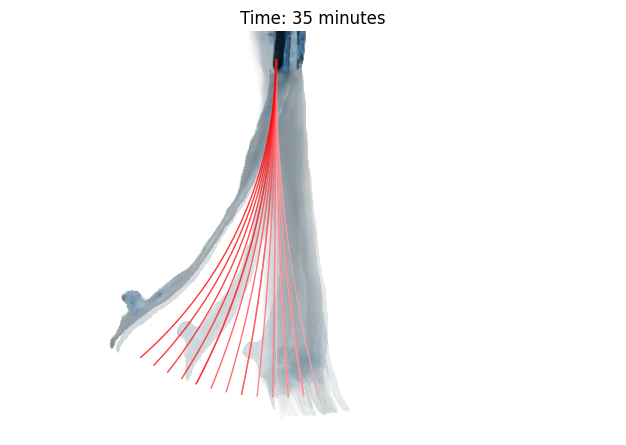

Processing composite for time point: 36 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14, 14]


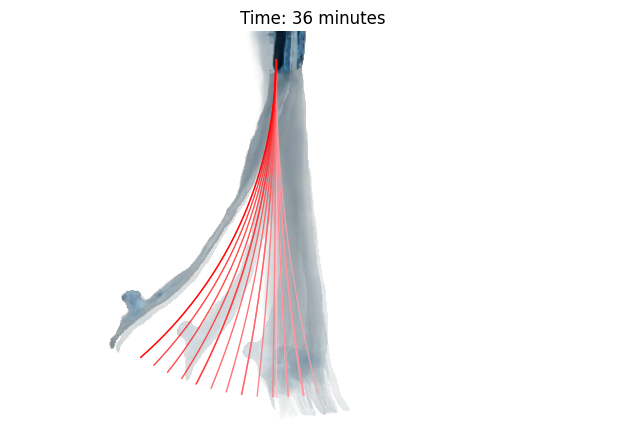

Processing composite for time point: 37 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14, 14, 15]


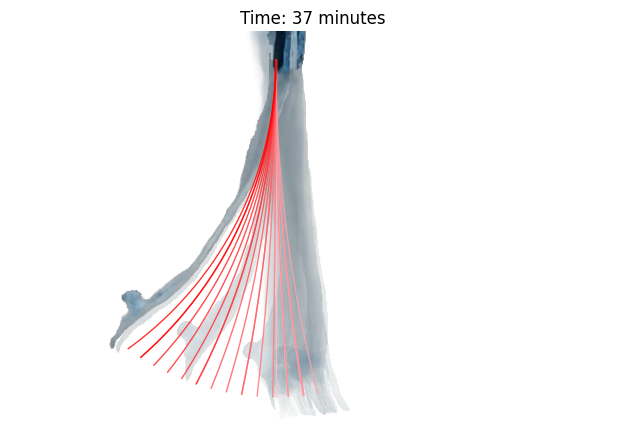

Processing composite for time point: 38 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14, 14, 15, 16]


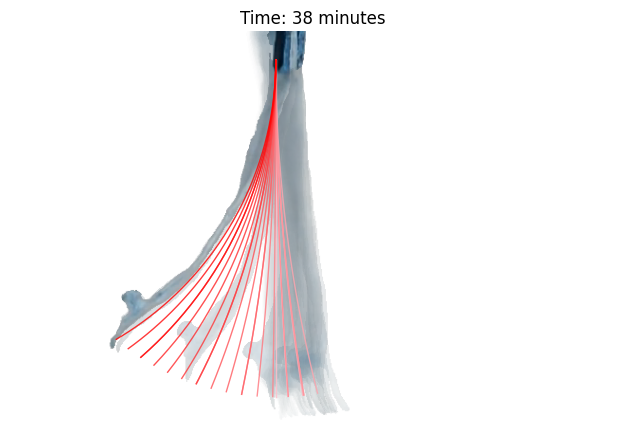

Processing composite for time point: 39 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14, 14, 15, 16, 17]


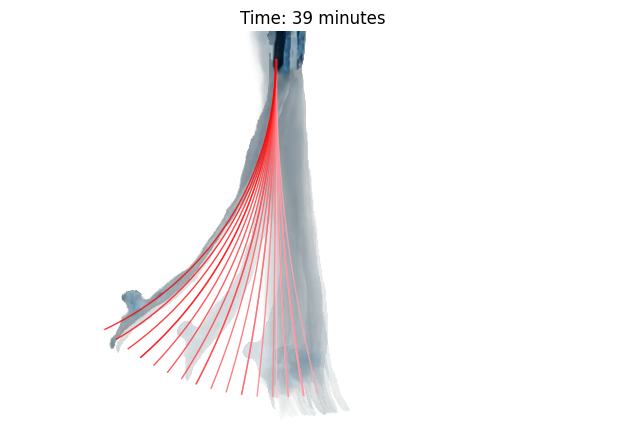

Processing composite for time point: 40 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14, 14, 15, 16, 17, 17]


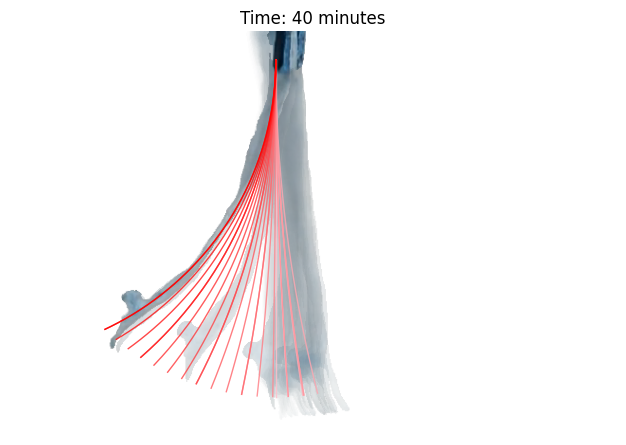

Processing composite for time point: 41 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14, 14, 15, 16, 17, 17, 18]


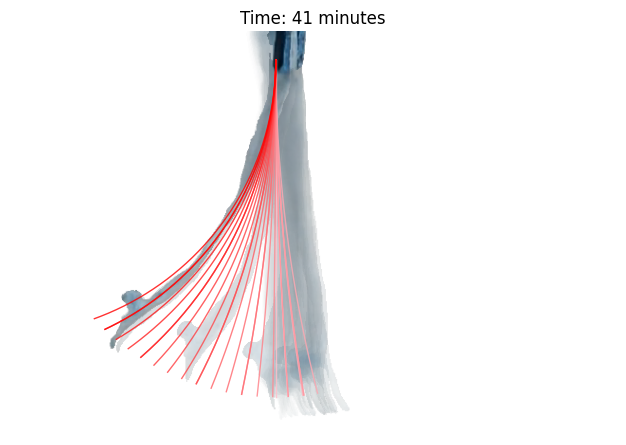

Processing composite for time point: 42 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14, 14, 15, 16, 17, 17, 18, 19]


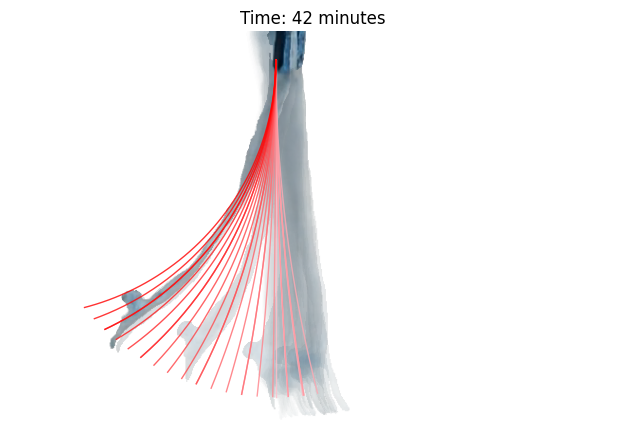

Processing composite for time point: 43 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14, 14, 15, 16, 17, 17, 18, 19, 20]


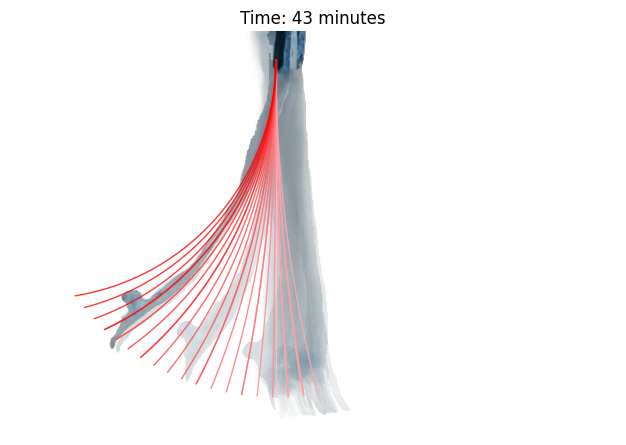

Processing composite for time point: 44 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14, 14, 15, 16, 17, 17, 18, 19, 20, 21]


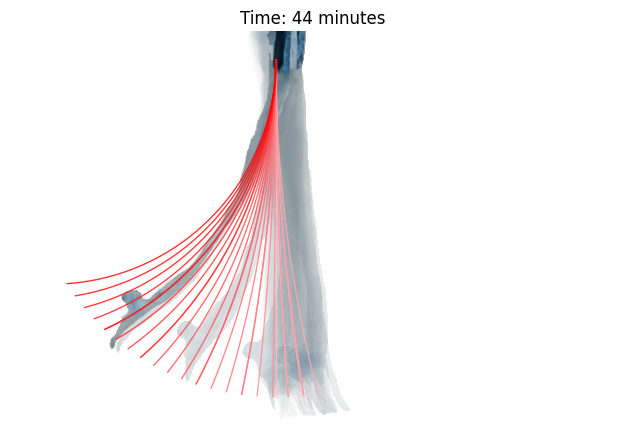

Processing composite for time point: 45 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14, 14, 15, 16, 17, 17, 18, 19, 20, 21, 21]


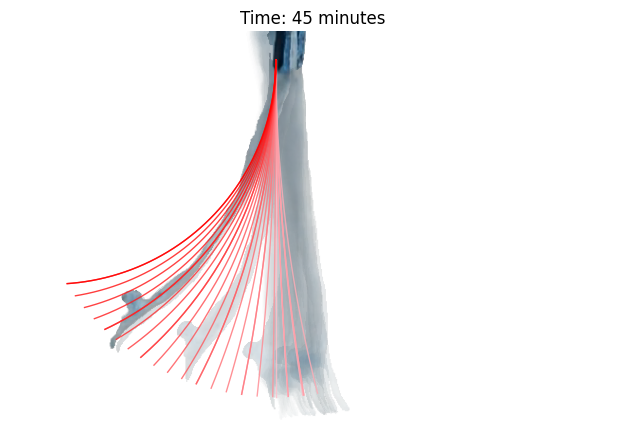

Processing composite for time point: 46 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14, 14, 15, 16, 17, 17, 18, 19, 20, 21, 21, 22]


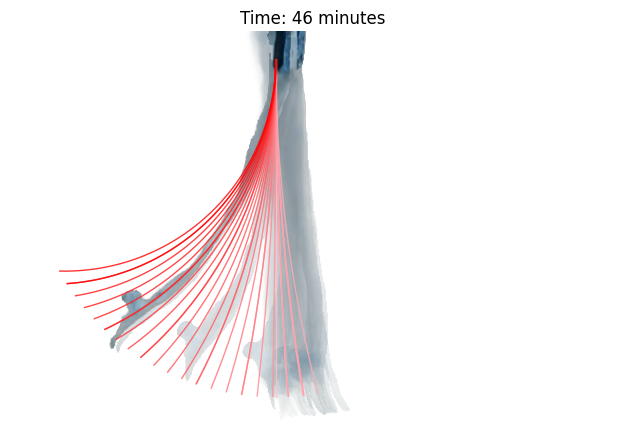

Processing composite for time point: 47 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14, 14, 15, 16, 17, 17, 18, 19, 20, 21, 21, 22, 23]


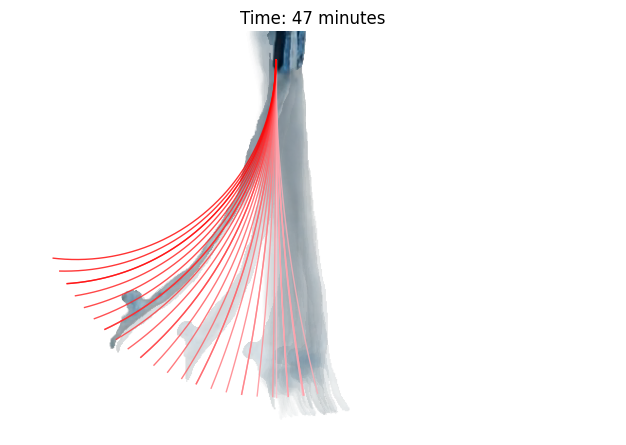

Processing composite for time point: 48 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14, 14, 15, 16, 17, 17, 18, 19, 20, 21, 21, 22, 23, 24]


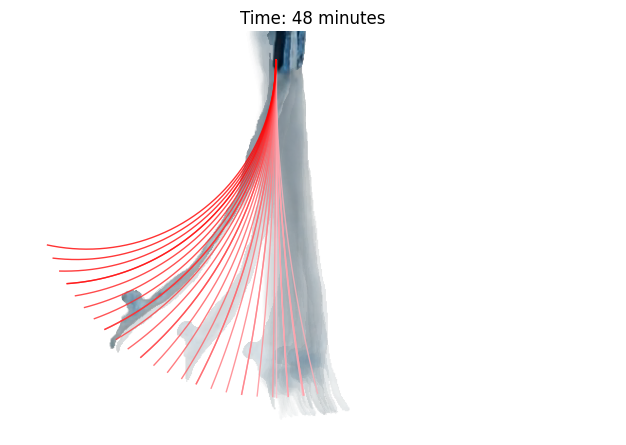

Processing composite for time point: 49 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14, 14, 15, 16, 17, 17, 18, 19, 20, 21, 21, 22, 23, 24, 24]


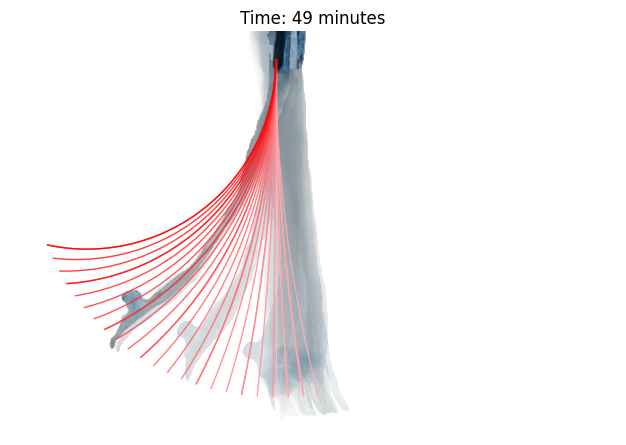

Processing composite for time point: 50 minutes
curvature_indices [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14, 14, 15, 16, 17, 17, 18, 19, 20, 21, 21, 22, 23, 24, 24, 25]


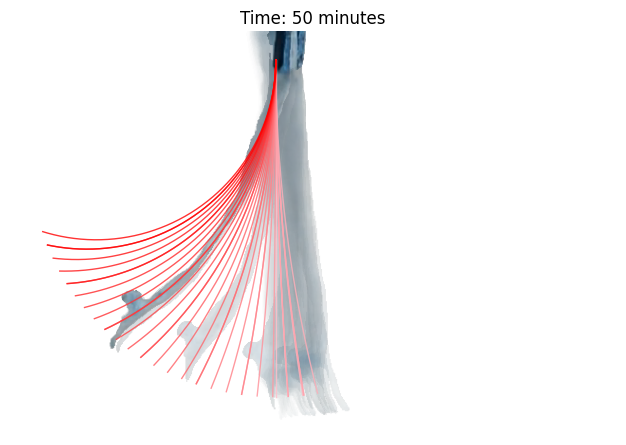

All composite images have been saved to beam_composite_output


In [424]:
movie_name = "bimorph_idx5_100x"
create_beam_tracking_composite(
    json_file_path=f"../tracked_trajectories/bimorph_idx5_100x_json.csv",
    video_path=f"../bimorph_videos/{movie_name}.mov",
    curvatures=curvatures,
    L_beam=L_beam,
    stalling_frames=17,#21,
    x_offset=280,
    y_offset=30,
    beam_scale_factor=1.2,
    time_points=range(0, 51, 1),
)

In [425]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Finished overaly

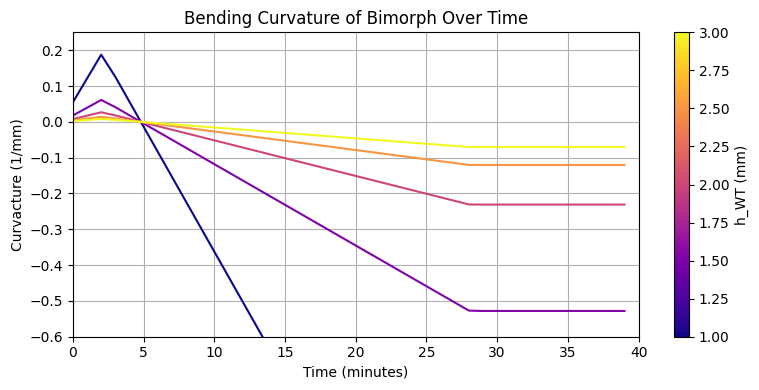

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors

# Example data: Replace this with your actual curvature data
# Create a list of h_WT values to loop over
h_WT_values = [1, 1.5, 2, 2.5, 3] #np.linspace(1, 10.0, 50)

# Create a colormap and normalization for color scaling
cmap = cm.plasma
norm = colors.Normalize(vmin=min(h_WT_values), vmax=max(h_WT_values))  # Range of h_WT values

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the curvature over time for each h_WT value
for h_WT in h_WT_values:
    curvatures, radii = [], []
    for s1, s2 in zip(WT_strain, BslA_strain):
        kappa, radius = calculate_timoshenko_curvature(h_WT / 1000, h_BslA, E_WT, E_BslA, s1, s2, C)
        curvatures.append(kappa / 1000)  # Convert curvature to 1/mm
        radii.append(radius * 1000)
    ax.plot(range(len(curvatures)), curvatures, label=f"h_WT = {h_WT:.5f} mm", color=cmap(norm(h_WT)))

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array for colorbar
fig.colorbar(sm, ax=ax, label="h_WT (mm)")  # Pass ax to colorbar

# Labels, title, and grid
ax.set_xlabel("Time (minutes)")
ax.set_ylabel("Curvacture (1/mm)")
ax.set_title("Bending Curvature of Bimorph Over Time")
ax.grid(True)
# ax.legend()

ax.set_ylim([-0.6, 0.25])
ax.set_xlim([0, 40])  



# Adjust layout to fit everything
plt.tight_layout()
plt.show()


In [ ]:
# import numpy as np
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# # Example data: Replace this with your actual curvature data
# # Create a list of h_WT values to loop over
# h_WT_values = [1, 2, 3, 4, 5]#np.linspace(1e-3, 10.0e-3, 100)

# # Create a colormap and normalization for color scaling
# cmap = 'Viridis'  # Use Plotly's predefined colormap
# norm = np.linspace(min(h_WT_values), max(h_WT_values), len(h_WT_values))  # Normalize h_WT values

# # Function to convert a tuple (r, g, b, a) into an rgb string
# def rgba_to_rgb_string(rgba):
#     return f'rgb({int(rgba[0] * 255)}, {int(rgba[1] * 255)}, {int(rgba[2] * 255)})'

# # Create a subplot figure
# fig = make_subplots(rows=1, cols=1)

# # Plot the curvature over time for each h_WT value
# for idx, h_WT in enumerate(h_WT_values):
#     # Replace this with your actual curvature data computation
#     curvatures = []
#     radii = []

#     for s1, s2 in zip(WT_strain, BslA_strain):
#         kappa, radius = calculate_timoshenko_curvature(h_WT / 1000, h_BslA, E_WT, E_BslA, s1, s2, C)
#         curvatures.append(kappa)
#         radii.append(radius)
    
#     # Get the RGBA color for this h_WT value
#     rgba = plt.cm.viridis(norm[idx])  # Get RGBA tuple
#     color_str = rgba_to_rgb_string(rgba)  # Convert to rgb string
    
#     # Plot the curvature for the current h_WT value
#     fig.add_trace(go.Scatter(
#         x=list(range(len(curvatures))),
#         y=curvatures,
#         mode='lines',
#         name=f"h_WT = {h_WT:.5f} mm",
#         line=dict(color=color_str),  # Set color as rgb string
#     ))

# # Add colorbar as a separate trace
# fig.update_layout(
#     title="Bending Curvature of Bimorph Over Time",
#     xaxis_title="Time (minutes)",
#     yaxis_title="Curvature (1/mm)",
#     coloraxis=dict(
#         colorscale=cmap,
#         cmin=min(h_WT_values),
#         cmax=max(h_WT_values),
#         colorbar=dict(title="h_WT (mm)")
#     ),
#     showlegend=True
# )

# fig.show()
